In [5]:
# MODEL 1: XGBoost with Hyperparameter Tuning
# ----------------------------------------------------
# Why XGBoost?
# XGBoost is a powerful machine learning model that can
# handle nonlinear patterns, multiple features, and
# large datasets efficiently. It’s widely used in
# forecasting competitions and provides excellent accuracy.
# ====================================================

# Step 1: Import required libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

In [6]:
# Step 2: Load the dataset
train = pd.read_csv('train.csv')
train.head()




,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,34,115850,2013-01-02,25767.0,6.0,False,2013,1,2,2,NaN
1,30,321798,2013-01-02,23302.0,1.0,False,2013,1,2,2,NaN
2,35,819195,2013-01-02,26945.0,1.0,False,2013,1,2,2,NaN
3,24,959500,2013-01-02,19641.0,5.0,False,2013,1,2,2,NaN
4,35,683721,2013-01-02,26892.0,3.0,False,2013,1,2,2,NaN


In [7]:
items = pd.read_csv('items - items.csv')
items.head()


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [9]:
stores = pd.read_csv('stores - stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
# Step 3: Merge store and item info
df = train.merge(stores, on='store_nbr', how='left')
df = df.merge(items, on='item_nbr', how='left')
df['date'] = pd.to_datetime(df['date'])
df

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,city,state,type,cluster,family,class,perishable
0,34,115850,2013-01-02,25767.0,6.0,False,2013,1,2,2,NaN,Guayaquil,Guayas,B,6,GROCERY I,1004,0
1,30,321798,2013-01-02,23302.0,1.0,False,2013,1,2,2,NaN,Guayaquil,Guayas,C,3,CLEANING,3010,0
2,35,819195,2013-01-02,26945.0,1.0,False,2013,1,2,2,NaN,Playas,Guayas,C,3,GROCERY I,1002,0
3,24,959500,2013-01-02,19641.0,5.0,False,2013,1,2,2,NaN,Guayaquil,Guayas,D,1,CLEANING,3034,0
4,35,683721,2013-01-02,26892.0,3.0,False,2013,1,2,2,NaN,Playas,Guayas,C,3,GROCERY I,1062,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,30,2011073,2017-08-15,125448576.0,11.0,False,2017,8,15,1,6.000000,Guayaquil,Guayas,C,3,GROCERY I,1032,0
299996,27,213066,2017-08-15,125441478.0,1.0,False,2017,8,15,1,2.142857,Daule,Guayas,D,1,GROCERY I,1074,0
299997,28,1146784,2017-08-15,125444374.0,1.0,False,2017,8,15,1,2.142857,Guayaquil,Guayas,E,10,GROCERY I,1040,0
299998,29,2013086,2017-08-15,125447219.0,4.0,False,2017,8,15,1,6.000000,Guayaquil,Guayas,E,10,BEVERAGES,1124,0


In [11]:
# Step 4: Aggregate daily sales
daily_sales = df.groupby(['date'], as_index=False)['unit_sales'].sum()


In [12]:
# Step 5: Create time-based features
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['dayofweek'] = daily_sales['date'].dt.dayofweek


In [13]:
# Additional time features
daily_sales['quarter'] = daily_sales['date'].dt.quarter  # NEW
daily_sales['dayofyear'] = daily_sales['date'].dt.dayofyear  # NEW

# Lag features (use past values to predict future)
for lag in [1, 7, 14]:  # NEW
    daily_sales[f'lag_{lag}'] = daily_sales['unit_sales'].shift(lag)

# Rolling mean features (moving averages)
for window in [7, 14, 30]:  # NEW
    daily_sales[f'rolling_mean_{window}'] = daily_sales['unit_sales'].rolling(window=window).mean()

# Clean data
daily_sales = daily_sales.dropna()  # NEW - Remove NaN from lag/rolling features

In [14]:
# Step 6: Split into train and validation
# Check the date range of daily_sales to determine a valid split point
# display(daily_sales['date'].min())
# display(daily_sales['date'].max())

# Based on the output, the max date is 2016-03-06, so we need to adjust the split date.
train_xgb = daily_sales[daily_sales['date'] < '2016-03-01']
valid_xgb = daily_sales[daily_sales['date'] >= '2016-03-01']

X_train = train_xgb.drop(['unit_sales', 'date'], axis=1)
y_train = train_xgb['unit_sales']
X_valid = valid_xgb.drop(['unit_sales', 'date'], axis=1)
y_valid = valid_xgb['unit_sales']

In [15]:
# Step 7: Baseline XGBoost model
start_time = time.time()
xgb_baseline = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_baseline.fit(X_train, y_train)
train_time_baseline = time.time() - start_time

y_pred_baseline = xgb_baseline.predict(X_valid)


In [16]:
# Step 8: Evaluate baseline model
mae_base = mean_absolute_error(y_valid, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_valid, y_pred_baseline))
mape_base = np.mean(np.abs((y_valid - y_pred_baseline)/y_valid))*100

print(f"Baseline -> MAE:{mae_base:.2f}, RMSE:{rmse_base:.2f}, MAPE:{mape_base:.2f}, Time:{train_time_baseline:.2f}s")


Baseline -> MAE:242.15, RMSE:419.04, MAPE:14.78, Time:0.28s


In [17]:
# Step 9: Hyperparameter tuning (Randomized Search)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'min_child_weight': [1, 3, 5]    # prevents overfitting
}

start_time = time.time()
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=10,verbose=1, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)
train_time_tuned = time.time() - start_time

best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_valid)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [18]:
# Step 9.1: Calculate and display feature importance
# Define feature_cols
feature_cols = X_train.columns

# Calculate and display feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance.head())


Top 5 Most Important Features:
            feature  importance
9    rolling_mean_7    0.286312
3         dayofweek    0.199028
7             lag_7    0.092263
10  rolling_mean_14    0.090895
0               day    0.066822


Shows which features actually help predictions
Can remove unimportant features to speed up training
Helps understand what drives sales

In [19]:
# Step 10: Evaluate tuned model
mae_tuned = mean_absolute_error(y_valid, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_tuned))
mape_tuned = np.mean(np.abs((y_valid - y_pred_tuned)/y_valid))*100

print(f"Tuned -> MAE:{mae_tuned:.2f}, RMSE:{rmse_tuned:.2f}, MAPE:{mape_tuned:.2f}, Time:{train_time_tuned:.2f}s")


Tuned -> MAE:256.39, RMSE:420.04, MAPE:15.94, Time:15.34s


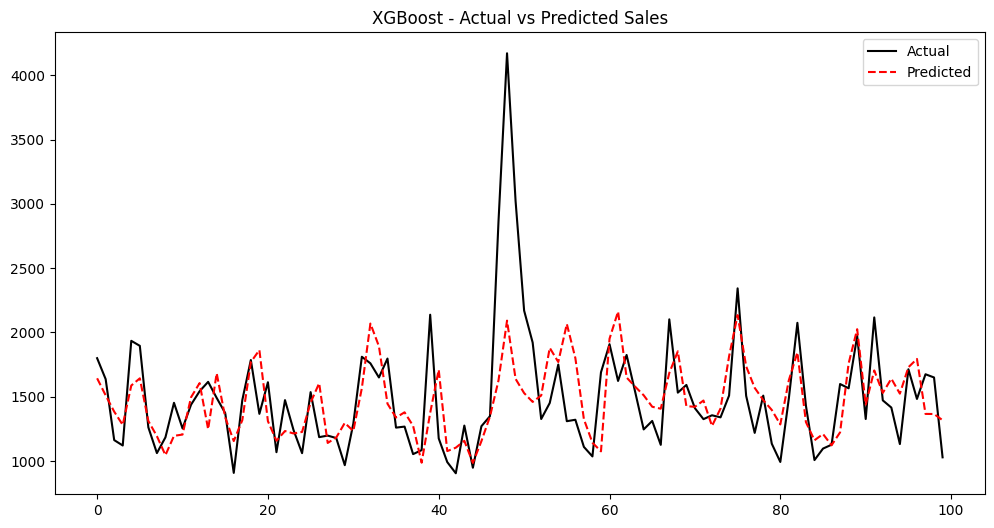

In [20]:
# Step 11: Visualize actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_valid.values[:100], label='Actual', color='black')
plt.plot(y_pred_tuned[:100], label='Predicted', color='red', linestyle='--')
plt.title("XGBoost - Actual vs Predicted Sales")
plt.legend()
plt.show()


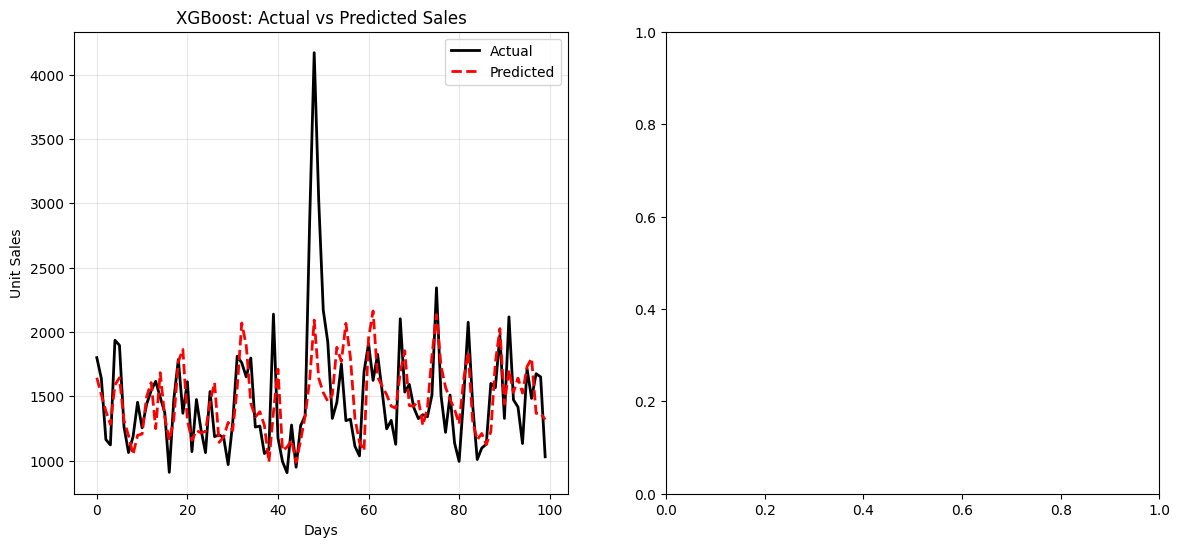

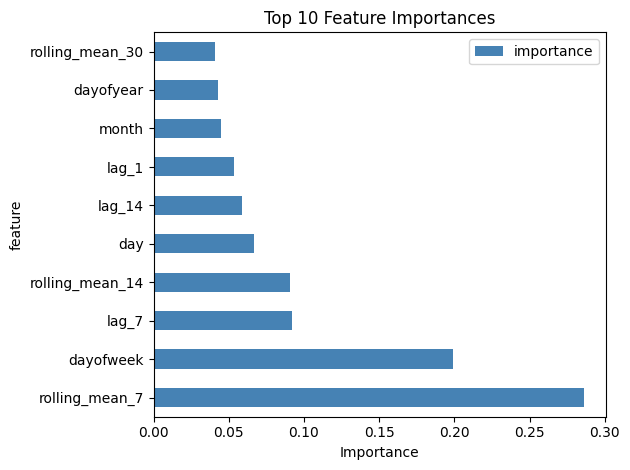

In [21]:
plt.figure(figsize=(14, 6))

# Plot 1: Actual vs Predicted (LEFT)
plt.subplot(1, 2, 1)
plt.plot(y_valid.values[:100], label='Actual', color='black', linewidth=2)
plt.plot(y_pred_tuned[:100], label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('XGBoost: Actual vs Predicted Sales', fontsize=12)
plt.xlabel('Days')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance (RIGHT) - NEW!
plt.subplot(1, 2, 2)
feature_importance.head(10).plot(x='feature', y='importance', kind='barh', color='steelblue')
plt.title('Top 10 Feature Importances', fontsize=12)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [22]:
#MODEL COMPARISON TABLE
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'Time (s)':<10}")
print("-" * 60)
print(f"{'Baseline XGBoost':<20} {mae_base:<10.2f} {rmse_base:<10.2f} {mape_base:<10.2f} {train_time_baseline:<10.2f}")
print(f"{'Tuned XGBoost':<20} {mae_tuned:<10.2f} {rmse_tuned:<10.2f} {mape_tuned:<10.2f} {train_time_tuned:<10.2f}")
print("="*60)

improvement = ((mae_base - mae_tuned) / mae_base) * 100
print(f"\nMAE Improvement: {improvement:.2f}%")


MODEL COMPARISON SUMMARY
Model                MAE        RMSE       MAPE       Time (s)  
------------------------------------------------------------
Baseline XGBoost     242.15     419.04     14.78      0.28      
Tuned XGBoost        256.39     420.04     15.94      15.34     

MAE Improvement: -5.88%
